In [51]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [52]:
import sys

In [53]:
!{sys.executable} -m pip install sklearn

In [54]:
!{sys.executable} -m pip install TfidfVectorizer

ERROR: Could not find a version that satisfies the requirement TfidfVectorizer (from versions: none)
ERROR: No matching distribution found for TfidfVectorizer


In [55]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score

In [56]:
df = pd.read_csv('fake_or_real_news.csv')

In [57]:
replacement = {'REAL':0,"FAKE":1}
df['label'].replace(replacement,inplace=True)
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [58]:
df['label'].value_counts()

0    3171
1    3164
Name: label, dtype: int64

In [59]:
df['combined'] = df['title'] + df['text']

In [60]:
X_train,X_test,y_train,y_test = train_test_split(df['combined'],df['label'],random_state=33,test_size=0.3,shuffle=True)

In [61]:
tf = TfidfVectorizer(stop_words=['english'])
train_vectorizer = tf.fit_transform(X_train)
test_vectors = tf.transform(X_test)

In [62]:
X_train = torch.tensor(train_vectorizer.toarray(),dtype=torch.float32)
Y_train = torch.tensor(y_train.values,dtype=torch.float32)
X_test = torch.tensor(test_vectors.toarray(),dtype=torch.float32)
Y_test = torch.tensor(y_test.values,dtype=torch.float32)

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [64]:
model = nn.Sequential( 
    nn.Linear(X_train.shape[1],128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.ReLU(),
    nn.Linear(10,1),
    nn.Sigmoid()
)
model.to(device)

Sequential(
  (0): Linear(in_features=61597, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
  (7): Sigmoid()
)

In [65]:
train_ds  = TensorDataset(X_train,Y_train)
train_dl = DataLoader(train_ds,batch_size=64,shuffle=True)
test_ds = TensorDataset(X_test,Y_test)
test_dl = DataLoader(test_ds,batch_size=64,shuffle=True)

In [66]:
criterion = torch.nn.BCELoss()

In [67]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

**Training Model**

In [68]:
num_epochs = 5
losses,accuracies = [],[]
for epoch in range(num_epochs):
    for x,y in train_dl:
        x,y = x.to(device),y.to(device)
        outputs = model(x)
        loss = criterion(outputs,y.unsqueeze(1))
        accuracy= (model(X_test.to(device)).cpu().reshape(-1).detach().numpy().round() == Y_test.to(device).cpu().detach().numpy()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    accuracies.append(accuracy)
    print(f"Epoch {epoch} Loss: {loss.item()} Accuracy: {accuracy}")

Epoch 0 Loss: 0.3952547311782837 Accuracy: 0.9226722777485534
Epoch 1 Loss: 0.09052130579948425 Accuracy: 0.9384534455549711
Epoch 2 Loss: 0.0032390975393354893 Accuracy: 0.9452919516044187
Epoch 3 Loss: 0.002393353031948209 Accuracy: 0.9395055234087323
Epoch 4 Loss: 0.0005238167941570282 Accuracy: 0.9463440294581799


In [69]:
torch.save(model.state_dict(),"model.pth")

In [70]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

**Testing Model**

In [77]:
torch.round(model(torch.tensor(tf.transform(["Donald Trump’s Shockingly Weak Delegate Game Somehow Got Even Worse"]).toarray(),dtype=torch.float32,device=device)).detach())

tensor([[0.]])

**Graph**

[0.3952547311782837, 0.09052130579948425, 0.0032390975393354893, 0.002393353031948209, 0.0005238167941570282]


Text(0, 0.5, 'loss')

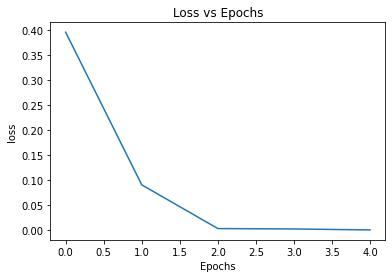

In [72]:
print(losses)
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

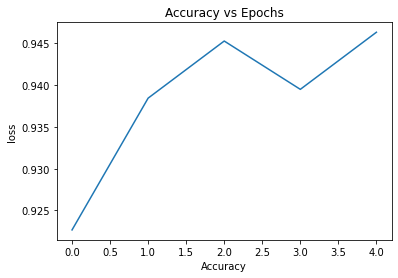

In [73]:
plt.plot(accuracies)
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')

**Confusion Matrix**

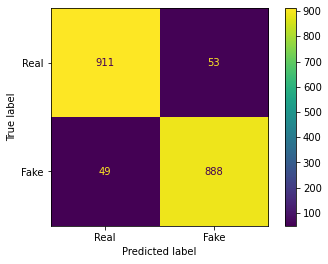

In [74]:
cm = confusion_matrix(model(X_test.to(device)).cpu().detach().numpy().round(),Y_test.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Real','Fake'])
disp.plot()

**F1 Score**

In [75]:
f1_score(model(X_test.to(device)).cpu().detach().numpy().round(),Y_test.numpy())

0.9456869009584664